In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, CubicSpline
import os 

#sys.path.insert(0,"/homes/o23gauvr/Documents/thèse/code/FASCINATION/")
running_path = "/Odyssey/private/o23gauvr/code/FASCINATION/"
os.chdir(running_path)

In [2]:
plt.style.use('ggplot')

In [3]:
cmap = plt.get_cmap('viridis')

In [4]:
data_path = "/Odyssey/public/enatl60/celerity/eNATL60_BLB002_sound_speed_regrid_0_botm.nc"


In [5]:
da = xr.open_dataarray(data_path)
da

<xarray.DataArray 'celerity' (time: 365, z: 300, lat: 240, lon: 240)>
[6307200000 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.0 32.05 32.1 32.15 32.2 ... 43.8 43.85 43.9 43.95
  * z        (z) float64 0.4805 1.559 2.794 ... 5.925e+03 5.975e+03 6.025e+03
  * time     (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00

In [6]:
max_depth = 2000
# Drop all lat coordinates presenting a nan for depths (z) inferior to 2000
# Select only data for depths < 2000
sub_da = da.sel(z=da.z.where(da.z < max_depth, drop=True))
# For each lat, check if there is any nan across time, z, and lon
lat_nan = sub_da.isnull().any(dim=["time", "z", "lon"])
# Get valid latitudes (i.e. where there is no nan)
valid_lats = lat_nan.where(lat_nan == False, drop=True).coords["lat"].values
# Select only the valid latitudes and drop all z coordinates superior to 2000.
da = da.sel(lat=valid_lats, z=da.z.where(da.z < max_depth, drop=True))

da


<xarray.DataArray 'celerity' (time: 365, z: 157, lat: 140, lon: 240)>
[1925448000 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.65 32.85 32.9 32.95 33.0 ... 41.0 41.05 41.1 41.15
  * z        (z) float64 0.4805 1.559 2.794 ... 1.937e+03 1.958e+03 1.98e+03
  * time     (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00

In [7]:
depth_arr = da.z.values

In [8]:
def get_min_max_idx(arr,axs=1, pad=True):
    grad = np.diff(arr,axis=axs)
    grad_sign = np.sign(grad)
    min_max = np.diff(grad_sign,axis=axs) 
    min_max = np.abs(np.sign(min_max))
    if pad:
        pad_width = [(0, 0)] * arr.ndim
        pad_width[axs] = (1, 1)
        min_max = np.pad(min_max, pad_width, 'constant', constant_values=1)
    return min_max


In [9]:
def reduce_signal(data, min_max_mask, axis=1, reduction_rank=1, interpolation="linear"):
    # Get the indices where min/max are detected
    min_max_indices = np.where(min_max_mask == 1)
    
    # Extract points to keep
    reduced_indices = np.sort(np.unique(min_max_indices[axis]))
    
    # Create new indices with intermediate points
    if reduction_rank > 0:
        new_indices = []
        for i in range(len(reduced_indices) - 1):
            new_indices.append(reduced_indices[i])
            interp_points = np.linspace(reduced_indices[i], reduced_indices[i+1], reduction_rank+2, endpoint=False)[1:]
            new_indices.extend(interp_points.astype(int))
        new_indices.append(reduced_indices[-1])
        reduced_indices = np.unique(new_indices)
    
    # Interpolation
    original_indices = np.arange(data.shape[axis])
    interpolated_data = np.take(data, reduced_indices, axis=axis)
    
    if interpolation == "linear":
        interpolator = interp1d(reduced_indices, interpolated_data, axis=axis, kind="linear", fill_value="extrapolate")
    elif interpolation == "spline":
        interpolator = CubicSpline(reduced_indices, interpolated_data, axis=axis)
    else:
        raise ValueError("Interpolation method must be 'linear' or 'spline'")
    
    return interpolator(original_indices)

In [10]:
signal = da.isel(time=0,lat=0,lon=0).values
signal

array([1532.63277163, 1532.64844413, 1532.65328533, 1532.64891738,
       1532.64215353, 1532.63883373, 1532.63909167, 1532.64285571,
       1532.6494749 , 1532.65745005, 1532.66481516, 1532.66670941,
       1532.65750814, 1532.63000304, 1532.56833374, 1532.43113327,
       1532.11032566, 1531.50501825, 1530.77729589, 1530.05537182,
       1529.38638825, 1528.78028133, 1528.22635464, 1527.71066111,
       1527.22384436, 1526.76423686, 1526.33665992, 1525.94739881,
       1525.59979926, 1525.29341207, 1525.02551018, 1524.79264092,
       1524.59157767, 1524.41981759, 1524.27543205, 1524.15748647,
       1524.06517248, 1523.99597988, 1523.9462148 , 1523.91200953,
       1523.89084987, 1523.88059366, 1523.87894403, 1523.88388435,
       1523.89262322, 1523.90226582, 1523.9100829 , 1523.91294232,
       1523.90760907, 1523.89164836, 1523.86385739, 1523.82449198,
       1523.77535553, 1523.71983874, 1523.66274324, 1523.60909405,
       1523.56261187, 1523.52523654, 1523.49731372, 1523.47727

In [11]:
min_max_mask = get_min_max_idx(signal,axs=0,pad=True)
min_max_mask

array([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1.])

In [12]:
interpolated_signal = reduce_signal(signal, min_max_mask , axis=0, reduction_rank=1, interpolation="linear")

In [13]:
axis=0
reduction_rank=1
data = signal

min_max_indices = np.where(min_max_mask == 1)

# Extract points to keep
reduced_indices = np.sort(np.unique(min_max_indices[axis]))

# Create new indices with intermediate points
if reduction_rank > 0:
    new_indices = []
    for i in range(len(reduced_indices) - 1):
        new_indices.append(reduced_indices[i])
        interp_points = np.linspace(reduced_indices[i], reduced_indices[i+1], reduction_rank+2, endpoint=False)[1:]
        new_indices.extend(interp_points.astype(int))
    new_indices.append(reduced_indices[-1])
    augmented_reduced_indices = np.unique(new_indices)

else:
    augmented_reduced_indices = []

# Interpolation
original_indices = np.arange(data.shape[axis])
min_max_data = np.take(data, reduced_indices, axis=axis)
base_data = np.take(data, augmented_reduced_indices, axis=axis)

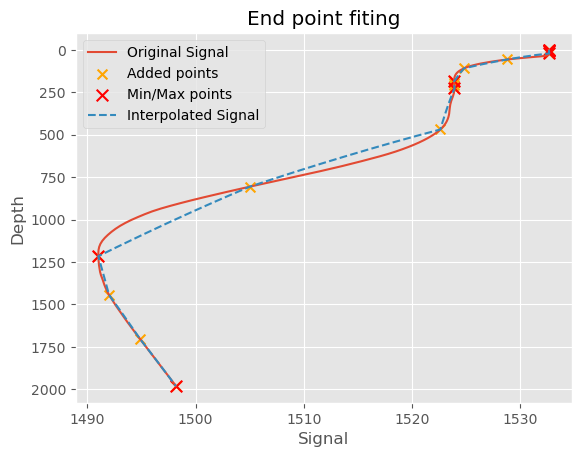

In [14]:
plt.plot(signal, depth_arr, label='Original Signal')
plt.gca().invert_yaxis()
plt.scatter(base_data, depth_arr[augmented_reduced_indices], c="orange", marker="x", s=50, label='Added points')
plt.scatter(min_max_data, depth_arr[reduced_indices], c="red", marker="x", s=70, label='Min/Max points')
plt.plot(interpolated_signal, depth_arr, ls='--', label='Interpolated Signal')
plt.title('End point fiting')
plt.xlabel('Signal')
plt.ylabel('Depth')
plt.legend()
plt.show()

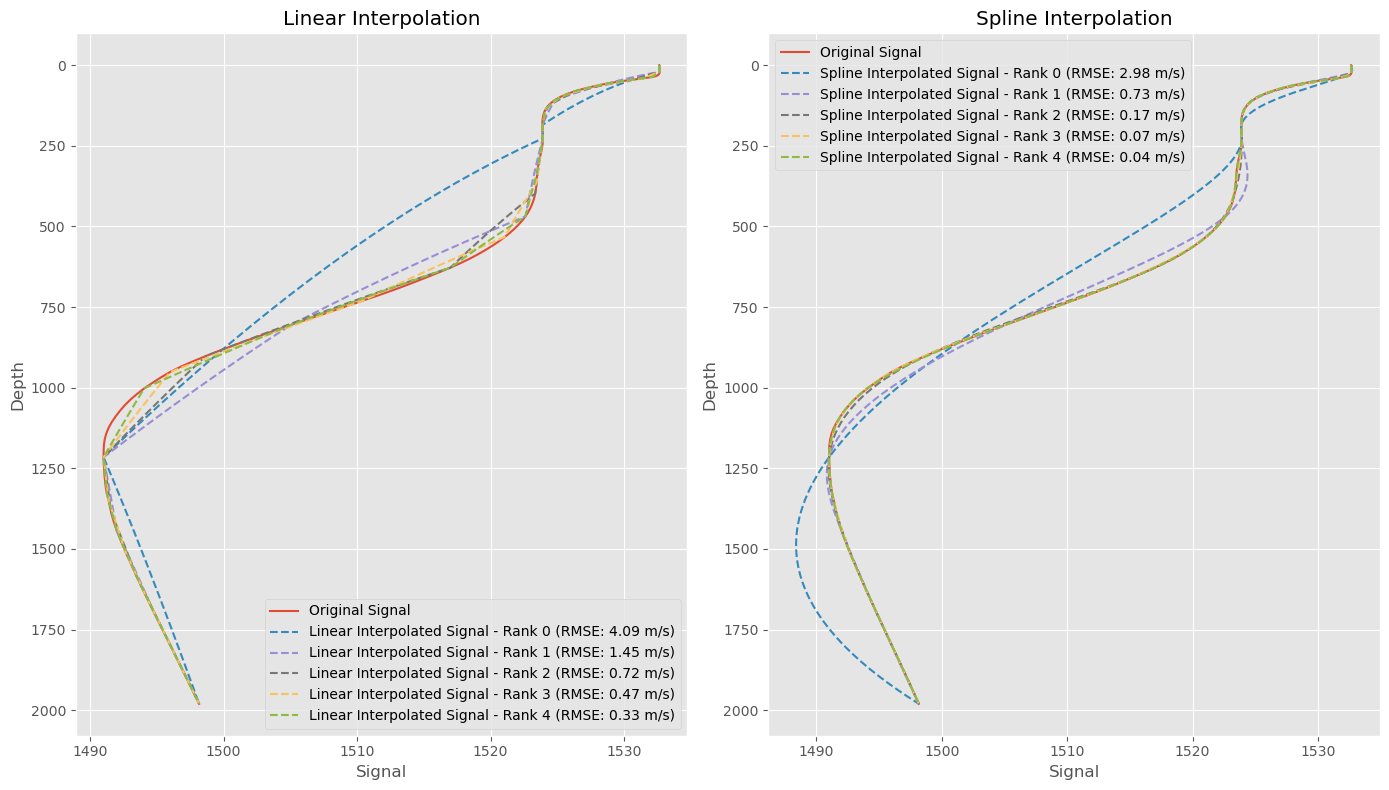

In [18]:
from sklearn.metrics import mean_squared_error

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Plot original signal on both subplots
ax1.plot(signal, depth_arr, label='Original Signal')
ax2.plot(signal, depth_arr, label='Original Signal')

for i in range(5):
    # Linear interpolation
    linear_interpolated_signal = reduce_signal(signal, min_max_mask, axis=0, reduction_rank=i, interpolation="linear")
    linear_rmse = np.sqrt(mean_squared_error(signal, linear_interpolated_signal))
    ax1.plot(linear_interpolated_signal, depth_arr, ls='--', label=f'Linear Interpolated Signal - Rank {i} (RMSE: {linear_rmse:.2f} m/s)')
    
    # Spline interpolation
    spline_interpolated_signal = reduce_signal(signal, min_max_mask, axis=0, reduction_rank=i, interpolation="spline")
    spline_rmse = np.sqrt(mean_squared_error(signal, spline_interpolated_signal))
    ax2.plot(spline_interpolated_signal, depth_arr, ls='--', label=f'Spline Interpolated Signal - Rank {i} (RMSE: {spline_rmse:.2f} m/s)')

# Invert y-axis for both subplots
ax1.invert_yaxis()
ax2.invert_yaxis()

# Set titles and labels
ax1.set_title('Linear Interpolation')
ax1.set_xlabel('Signal')
ax1.set_ylabel('Depth')
ax1.legend()

ax2.set_title('Spline Interpolation')
ax2.set_xlabel('Signal')
ax2.set_ylabel('Depth')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
data = da.data

In [ ]:
# all_min_max_mask = get_min_max_idx(data,axs=1,pad=True)
# all_min_max_mask

array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [ ]:
# interpolated_data = reduce_signal(data, all_min_max_mask, axis=1, reduction_rank=1, interpolation="linear")

In [ ]:
# pooling_model = NoConvAE(n_layer, pooling_dim=pooling_dim, pooling_mode="Avg")

# min_max_idx = get_min_max_idx(test_ssp_arr, axs=1, pad=True)

# reduced_indices = get_interpolation_points_idx(min_max_idx, axis=1, reduction_rank=i)

# interpolated_points = np.take(test_ssp_arr, reduced_indices, axis=1)

# interpolated_points_tens = torch.tensor(interpolated_points)

# pooled_upsampled_interpolated_points = pooling_model(interpolated_points_tens).detach().numpy()

# cr = input_size/pooling_model.bottleneck.numel()

# interpolator = CubicSpline(reduced_indices, pooled_upsampled_interpolated_points, axis=1)

# interpolated_ssp_arr = interpolator(np.arange(test_ssp_arr.shape[1]))


# ssp_rmse = np.sqrt(np.mean((test_ssp_arr - interpolated_ssp_arr) ** 2))

# ecs_interpolated_idx = np.argmax(interpolated_ssp_arr,axis=1)
# ecs_interpolated = depth_array[ecs_interpolated_idx]

# ecs_rmse = np.sqrt(np.mean((ecs_truth - ecs_interpolated) ** 2))        

# min_max_idx_interpolated = get_min_max_idx(interpolated_ssp_arr, axis =1, pad=False)
# mean_number_error_min_max = np.mean(np.abs(np.sum(min_max_idx_truth,axis=1) - np.sum(min_max_idx_interpolated,axis=1)))

# F1_score = get_f1_score(min_max_idx_truth, min_max_idx_interpolated, axs=1, kernel_size=10)


# rmse_dict["SSP"][f"Pool_upsample_{n_layer}_layers"][f"reduction_rank_{i}"] = ssp_rmse
# rmse_dict["ECS"][f"Pool_upsample_{n_layer}_layers"][f"reduction_rank_{i}"] = ecs_rmse
# rmse_dict["mean_error_n_min_max"][f"Pool_upsample_{n_layer}_layers"][f"reduction_rank_{i}"] = mean_number_error_min_max
# rmse_dict["F1_score"][f"Pool_upsample_{n_layer}_layers"][f"reduction_rank_{i}"] = F1_score
# rmse_dict["cr"][f"Pool_upsample_{n_layer}_layers"][f"reduction_rank_{i}"] = cr
